In [1]:
import scanpy as sc
import scvi
import muon as mu

In [2]:
mudata = mu.read("/home/icb/dominik.klein/git_repos/moscot_revisions/scMultiome_Mouse-Islets_NVF_E14-E16/scMultiome_Mouse-Islets_NVF_E14-E16_mdata_markedDoublets_mergedPeaks_normalized_rmDoublets.h5mu")

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [3]:
adata = mudata["atac"].copy()

In [4]:
scvi.external.POISSONVI.setup_anndata(adata, layer="atac_raw_counts", batch_key="sample")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
model = scvi.external.POISSONVI(adata, n_layers=4, n_latent=30)
model.train(max_epochs=25)


/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/scvi-tools/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/scvi-tools/l ...
  rank_zero_warn(
You are using a CUDA device ('NVID

Epoch 25/25: 100%|██████████| 25/25 [09:51<00:00, 23.79s/it, v_num=1, train_loss_step=4.34e+4, train_loss_epoch=4.41e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [09:51<00:00, 23.65s/it, v_num=1, train_loss_step=4.34e+4, train_loss_epoch=4.41e+4]


In [9]:
POISSONVI_LATENT_KEY = "X_poissonvi"

latent = model.get_latent_representation()
adata.obsm[POISSONVI_LATENT_KEY] = latent

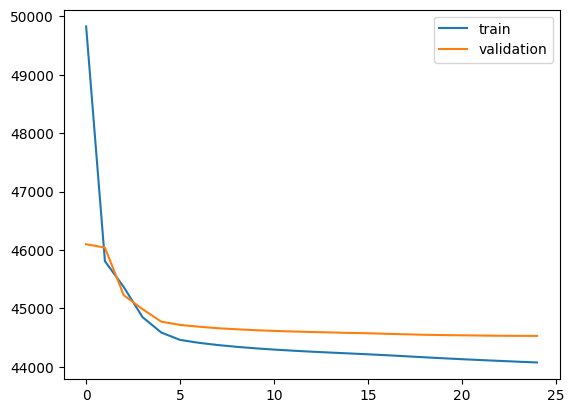

In [10]:
import matplotlib.pyplot as plt
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')
plt.legend()

In [11]:
sc.pp.neighbors(adata, use_rep=POISSONVI_LATENT_KEY)
sc.tl.umap(adata)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


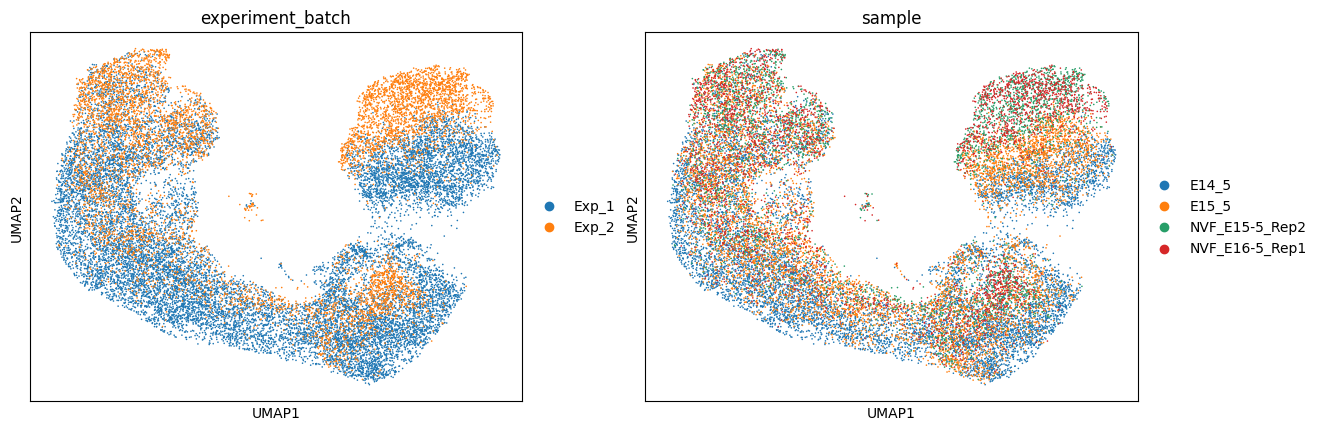

In [12]:
sc.pl.umap(adata, color=["experiment_batch", "sample"])

In [13]:
adata.layers["X_ATAC_reconstruction"] = model.get_accessibility_estimates(threshold=0.1, transform_batch="E15_5")

In [14]:
adata.X = adata.layers["X_ATAC_reconstruction"]
mu.atac.tl.lsi(adata)


In [15]:
import numpy as np
adata.obs["n_counts_ATAC_normalized"] = np.sum(adata.X, axis=1)

In [16]:
for i in range(49):
    print(np.corrcoef(adata.obsm["X_lsi"][:,i], adata.obs["n_counts_ATAC_normalized"])[0,1])

-0.008660918120893743
-0.007213391759882563
-0.009941146521790584
-0.003398903137106377
0.009632257333174804
-0.006964145648574733
0.007519566662107623
0.007026260911622275
-0.0019894608953355077
0.0022274497466788024
0.0003538723294388523
-0.0043948154762901235
0.002512150709406705
0.00529745969495135
-0.006383681175824596
0.00798073173372708
0.0021106121752237153
0.0024158113704499475
-0.01230820041828243
0.00112612342889369
-0.002883587618855918
0.0033787674826630675
-0.0023860768565881715
-0.008633847164963996
0.0047849839263653954
-0.007116389382773612
-0.0035858984165707893
0.004181589996203836
-0.0003473848556435296
-0.0075114771269326475
0.009097796403542807
0.0017338664739168445
-0.0007145897548021278
-0.006159153469572018
0.007333274224995611
-0.0006469744725351542
0.0010490373020123132
0.01020207159527186
0.005808748976660861
0.004003506800191173
0.0047202345515675445
0.002852303023936548
0.0062609092941231315
-0.0034193484851942806
-0.007413807411903088
0.000654381979861160

In [17]:
#to_keep = list(set(range(adata.obsm["X_lsi"].shape[1])) - {0, 1, 2})
#adata.obsm["X_lsi_red"] = adata.obsm["X_lsi"][:,to_keep]

In [18]:
sc.pp.neighbors(adata, use_rep="X_lsi")

In [19]:
sc.tl.umap(adata)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


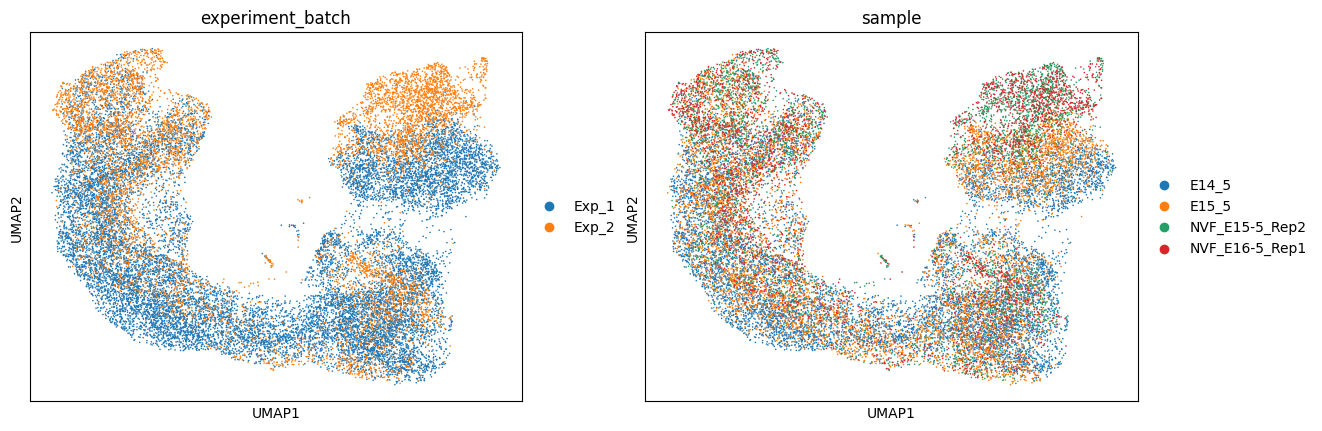

In [20]:
sc.pl.umap(adata,color=["experiment_batch", "sample"])

In [25]:
sc.tl.leiden(adata, resolution=0.6)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


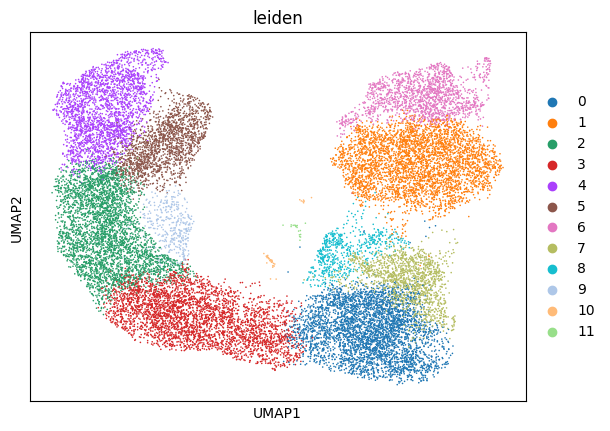

In [26]:
sc.pl.umap(adata, color="leiden")

In [27]:
mudata["rna"].obs["leiden_new"] = adata.obs["leiden"]

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


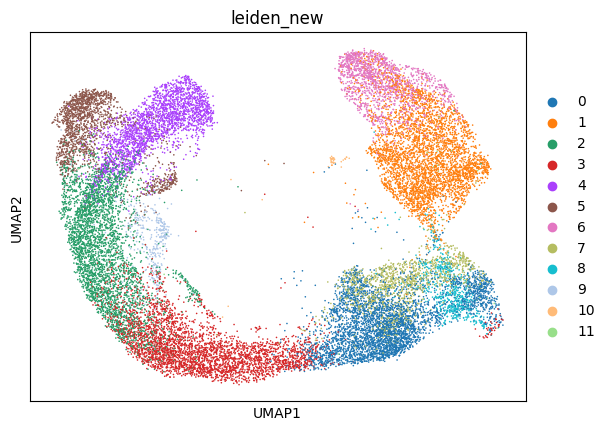

In [28]:
sc.pl.umap(mudata["rna"], color="leiden_new")

In [29]:
adata.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/adata_atac_PoissonVI_full.h5ad")